In [6]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import xarray as xr
import numpy as np
import admix
import matplotlib.pyplot as plt
import dask
import dask.array as da
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
from admix.data import quantile_normalize
import pandas as pd

import sys
sys.path.append("../../")
import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Export data to PLINK to perform GWAS

In [7]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
trait_list = pd.read_excel(SUPP_TABLE_URL, sheet_name='trait-info')['trait'].values

In [10]:
dset = common.load_page_hm3()

df_pheno = pd.DataFrame({"FID": 0, "IID": dset['indiv'].values})
for trait in trait_list:
    df_pheno[trait] = quantile_normalize(dset[f"{trait}"].values)
                          
df_covar = pd.DataFrame({"FID": 0, "IID": dset['indiv'].values})

for col in ["age", "sex", "study"] + [f"geno_EV{i}" for i in range(1, 11)]:
    df_covar[col] = dset[col].values

100%|██████████| 22/22 [00:00<00:00, 68.08it/s]


In [48]:
# for trait in trait_list:
#     non_nan_index = ~np.isnan(df_pheno[trait])
#     df_trait_pheno = df_pheno.loc[non_nan_index, ["FID", "IID", trait]].copy()
#     df_trait_covar = df_covar[non_nan_index].copy()
#     study_dummies = pd.get_dummies(df_trait_covar["study"], drop_first=True)
#     study_dummies.columns = [f"study_dummy_{s}" for s in study_dummies.columns]
#     df_trait_covar = pd.concat([df_trait_covar, study_dummies], axis=1)
#     df_trait_covar = df_trait_covar.drop(columns=["study"])
#     df_trait_pheno.to_csv(f"out/plink_assoc/pheno.{trait}.txt", index=False, sep='\t', na_rep="NA")
#     df_trait_covar.to_csv(f"out/plink_assoc/covar.{trait}.txt", index=False, sep='\t', na_rep="NA")

# Overall visualization of results

In [11]:
trait_list

array(['crp', 'total_wbc_cnt', 'mean_corp_hgb_conc', 'platelet_cnt',
       'hdl', 'ldl', 'triglycerides', 'total_cholesterol',
       'cigs_per_day_excl_nonsmk_updated', 'coffee_cup_day', 'a1c',
       'insulin', 'glucose', 't2d_status', 'qt_interval', 'qrs_interval',
       'pr_interval', 'systolic_bp', 'diastolic_bp', 'hypertension',
       'waist_hip_ratio', 'height', 'bmi', 'egfrckdepi'], dtype=object)

<ipython-input-12-9bec579d4e64>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 1), dpi=150)


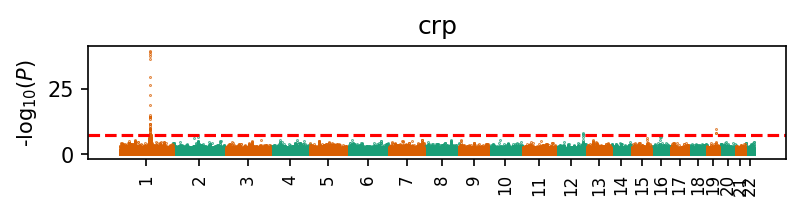

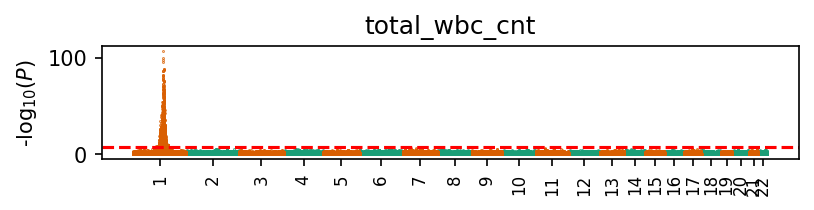

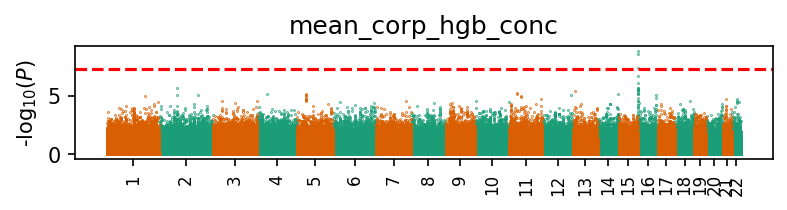

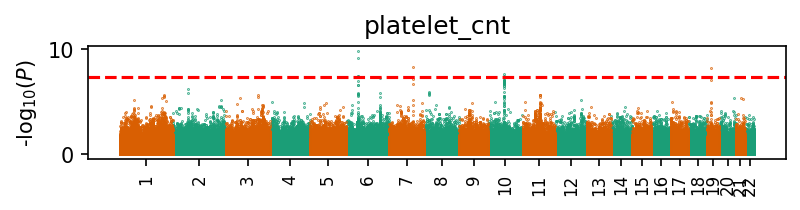

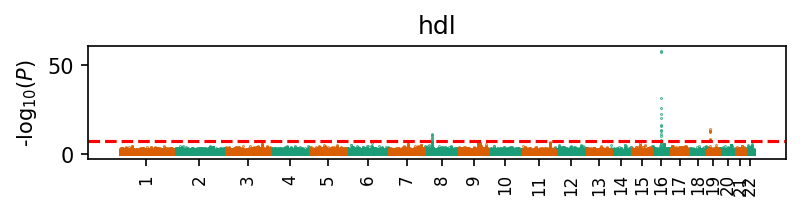

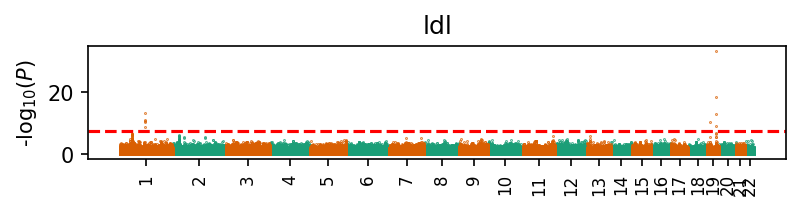

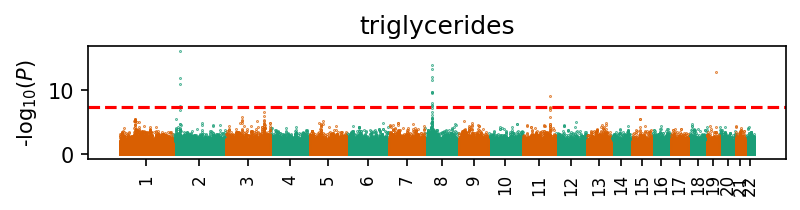

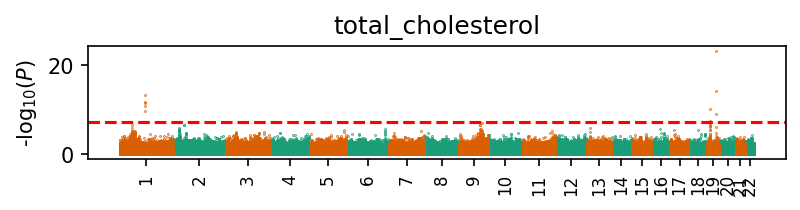

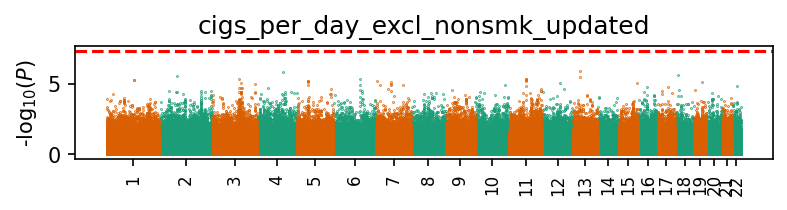

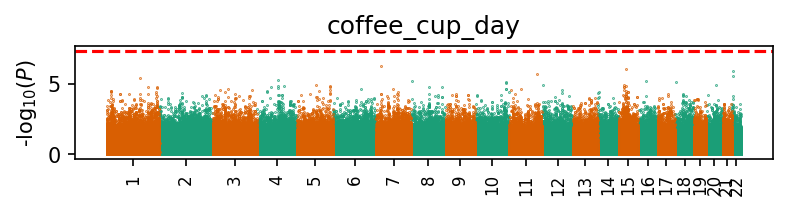

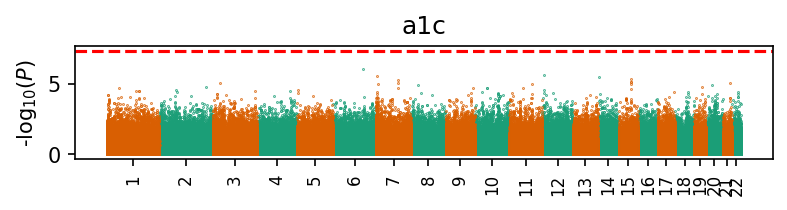

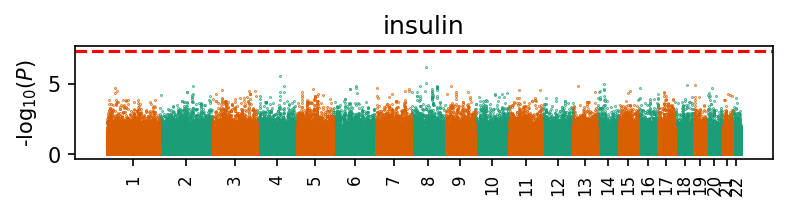

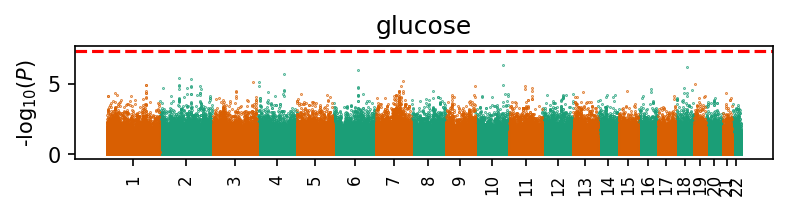

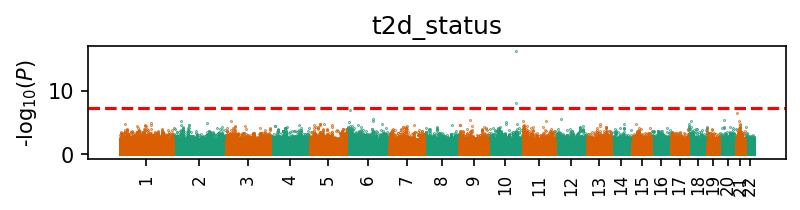

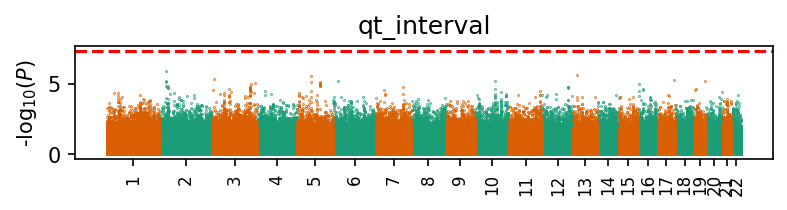

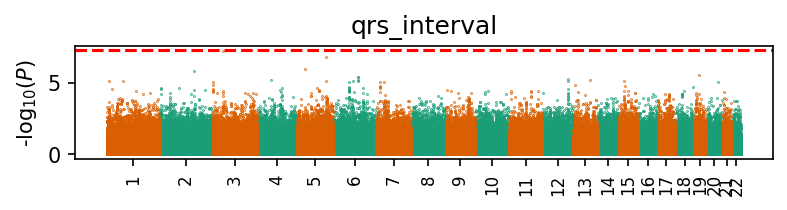

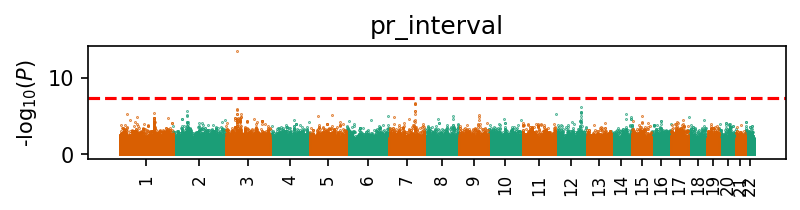

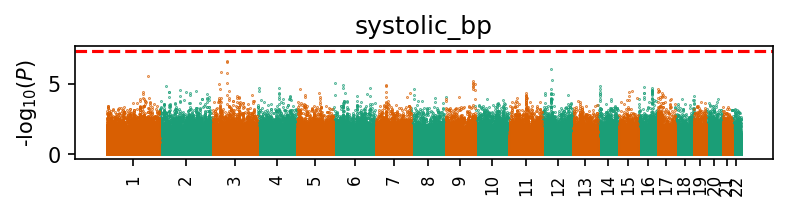

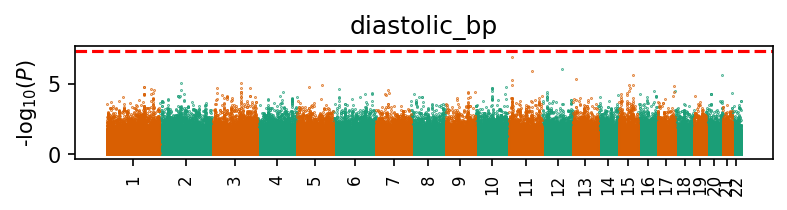

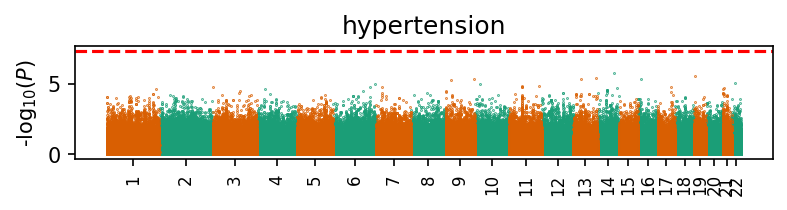

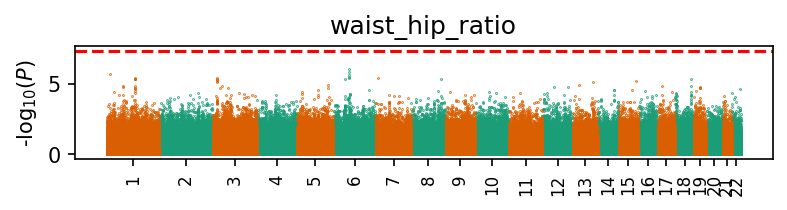

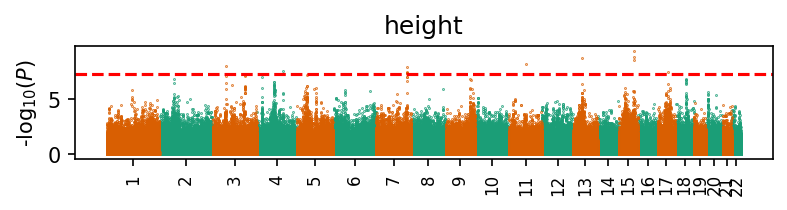

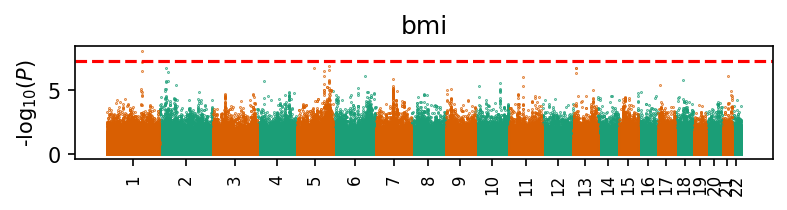

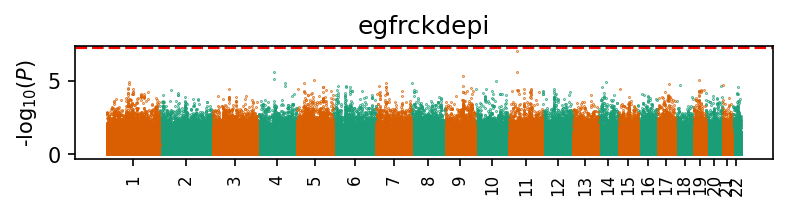

In [12]:
for trait in trait_list:
    assoc = pd.read_csv(f"out/plink_assoc/assoc.{trait}.glm.linear", delim_whitespace=True)
    fig, ax = plt.subplots(figsize=(6, 1), dpi=150)
    admix.plot.manhattan(pval=assoc["P"].values, chrom=assoc["#CHROM"].values, ax=ax)
    ax.set_title(trait)
    fig.show()

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import statsmodels.api as sm
from scipy import stats
import admix
import xarray as xr
import numpy as np

In [96]:
def simulate(apa, beta, cov):
    cov_effects = np.random.normal(loc=0, scale=0.1, size=cov.shape[1])
    y = np.dot(apa, beta) + np.dot(cov, cov_effects) + np.random.normal(size=apa.shape[0])
    return y

def test_het(apa, y, cov):
    design = sm.add_constant(np.hstack([apa, cov]))
    model = sm.OLS(y, design).fit()
    
    A = np.zeros([1, len(model.params)])
    A[0, 1] = 1
    A[0, 2] = -1
    p_ftest = model.f_test(A).pvalue.item()
    return p_ftest, model

#     design2 = sm.add_constant(np.hstack([apa.sum(axis=1)[:, np.newaxis], cov]))
#     m2 = sm.OLS(y, design2).fit()

#     # likelihood-ratio test
#     p_lrt = stats.chi2.sf(-2 * (m2.llf - m1.llf), 1)

